<a href="https://colab.research.google.com/github/apal9569/Image-Captioning/blob/master/img_cap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import keras
import os
import matplotlib.pyplot as plt
from keras import layers
from keras.layers import Dense, LSTM, Dropout,Input,Embedding
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Model
from keras.preprocessing.image import load_img,img_to_array
#from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import pandas as pd
import string
from collections import Counter
from copy import copy

In [0]:
def loadFile(flname):
    file=open(flname,'r')
    text=file.read()
    file.close()
    return text
flname="/home/ankit/data set/Flickr8k_text/Flickr8k.token.txt"
lemmatext=loadFile(flname)
#print(lemmatext)

FileNotFoundError: ignored

In [0]:
def load_desc(lemmatext):
    intface=[]
    for line in lemmatext.split('\n'):
        word=line.split('\t')
        if len(line)<2:
            continue
        ids=word[0].split('#')
        intface.append(ids+[word[1].lower()])
      
        
    return intface
description=load_desc(lemmatext)
act_desc=pd.DataFrame(description,columns=["file","index","caption"])
filename=np.unique(act_desc.file.values)
Counter(Counter(act_desc.file.values).values())

Counter({5: 8092})

In [0]:
def clean(description):
    descrip=description.translate(string.punctuation)
    descript=""
    for word in descrip.split():
        if len(word)>1:
            descript+=" "+word
    descriptions=""
    for word in descript.split():
        alpha=word.isalpha()
        if alpha:
            descriptions+=" "+word
    return(description)

In [0]:
for i,caption in enumerate(act_desc.caption.values):
    captions=clean(caption)
    act_desc["caption"].iloc[i]=captions

In [0]:
def start_end(cap):
    captions=[]
    for sentence in cap:
        sentence='startseq '+sentence+' endseq'
        captions.append(sentence)
    return(captions)
act_desc1=copy(act_desc)
act_desc1["caption"]=start_end(act_desc["caption"])
del act_desc
print(act_desc1["caption"])

0        startseq a child in a pink dress is climbing u...
1        startseq a girl going into a wooden building ....
2        startseq a little girl climbing into a wooden ...
3        startseq a little girl climbing the stairs to ...
4        startseq a little girl in a pink dress going i...
5        startseq a black dog and a spotted dog are fig...
6        startseq a black dog and a tri-colored dog pla...
7        startseq a black dog and a white dog with brow...
8        startseq two dogs of different breeds looking ...
9        startseq two dogs on pavement moving toward ea...
10       startseq a little girl covered in paint sits i...
11       startseq a little girl is sitting in front of ...
12       startseq a small girl in the grass plays with ...
13       startseq there is a girl with pigtails sitting...
14       startseq young girl with pigtails painting out...
15       startseq a man lays on a bench while his dog s...
16       startseq a man lays on the bench to which a wh.

In [0]:
model1=VGG19(weights='imagenet')
model=Model(model1.input,model1.layers[-2].output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
images=os.listdir("/home/ankit/data set/Flickr8k_Dataset/Flicker8k_Dataset")



encoding={}
for x,img in enumerate(images):
    file="/home/ankit/data set/Flickr8k_Dataset/Flicker8k_Dataset"+"/"+img
    image=load_img(file, target_size=(224,224,3))
    image=img_to_array(image)
    pro_image=preprocess_input(image)
    features=model.predict(pro_image.reshape((1,)+pro_image.shape[:3]))
    #features=np.reshape(features,features.shape[1])
    encoding[img]=features.flatten()

In [0]:
imgs,indx=[],[]
act_desc1=act_desc1.loc[act_desc1["index"].values=="2",:]
for i,file in enumerate(act_desc1.file):
    if file in encoding.keys():
        imgs.append(encoding[file])
        indx.append(i)

files=act_desc1["file"].iloc[indx].values
capt=act_desc1["caption"].iloc[indx].values
imgs=np.array(imgs)

In [0]:
tokens=Tokenizer(num_words=8000)
tokens.fit_on_texts(capt)
vocab_size=len(tokens.word_index)+1
texts=tokens.texts_to_sequences(capt)


In [0]:
train=int(len(texts)*.60)
def tra_test(text_image_file,train):
    return(text_image_file[:train],text_image_file[train:])
text_train,text_test=tra_test(texts,train)
imgs_train,imgs_test=tra_test(imgs,train)
files_train,files_test=tra_test(files,train)

In [0]:
maxlen=np.max([len(t) for t in texts])
def preprocess(texts,imgs):
    assert(len(texts)==len(imgs))
    Xtxt, Ximg, Ytxt=[],[],[]
    for txt,im in zip(texts,imgs):
        for i in range(1,len(txt)):
            in_txt,out_txt=txt[:i],txt[i]
            in_txt=pad_sequences([in_txt],maxlen=maxlen).flatten()
            out_txt=to_categorical(out_txt,num_classes=vocab_size)
            Xtxt.append(in_txt)
            Ximg.append(im)
            Ytxt.append(out_txt)
    Xtxt=np.array(Xtxt)
    Ximg=np.array(Ximg)
    Ytxt=np.array(Ytxt)
    return(Xtxt,Ximg,Ytxt)
Xtxt_train,Ximg_train,Ytxt_train=preprocess(text_train,imgs_train)

In [0]:
emb_dim=64

img_in=Input(shape=(Ximg_train.shape[1],))
layer_1=Dense(256,activation='relu',name="ImageFeature")(img_in)
txt_in=Input(shape=(maxlen,))
text_1=Embedding(vocab_size,emb_dim,mask_zero=True)(txt_in)
lstm_1=LSTM(256,name="CaptionFeature")(text_1)

Decode_1=layers.add([lstm_1,layer_1])
Decode_1=Dense(256,activation='relu')(Decode_1)
out=Dense(vocab_size,activation='softmax')(Decode_1)
model=Model(inputs=[img_in,txt_in],outputs=out)

model.compile(loss='categorical_crossentropy',optimizer='RMSprop')

In [0]:
training=model.fit([Ximg_train,Xtxt_train],Ytxt_train,epochs=4,verbose=1,batch_size=128)

Epoch 1/4
73652/73652 [==============================] - 179s 2ms/step - loss: 4.7504
Epoch 2/4
73652/73652 [==============================] - 172s 2ms/step - loss: 3.9597
Epoch 3/4
73652/73652 [==============================] - 180s 2ms/step - loss: 3.7129
Epoch 4/4
73652/73652 [==============================] - 202s 3ms/step - loss: 3.5704


In [0]:
ind_word=dict([(indx,word) for word,indx in tokens.word_index.items()])
def predict(img):
    in_text='startseq'
    for iword in range(maxlen):
        seq=tokens.texts_to_sequences([in_text])[0]
        seq=pad_sequences([seq],maxlen)
        y_pred=model.predict([img,seq],verbose=1);
        y_pred=np.argmax(y_pred)
        nword=ind_word[y_pred]
        in_text+=" "+nword
        if nword=="endseq":
            break
    return(in_text)


1/1 [==============================] - 0s 10ms/step


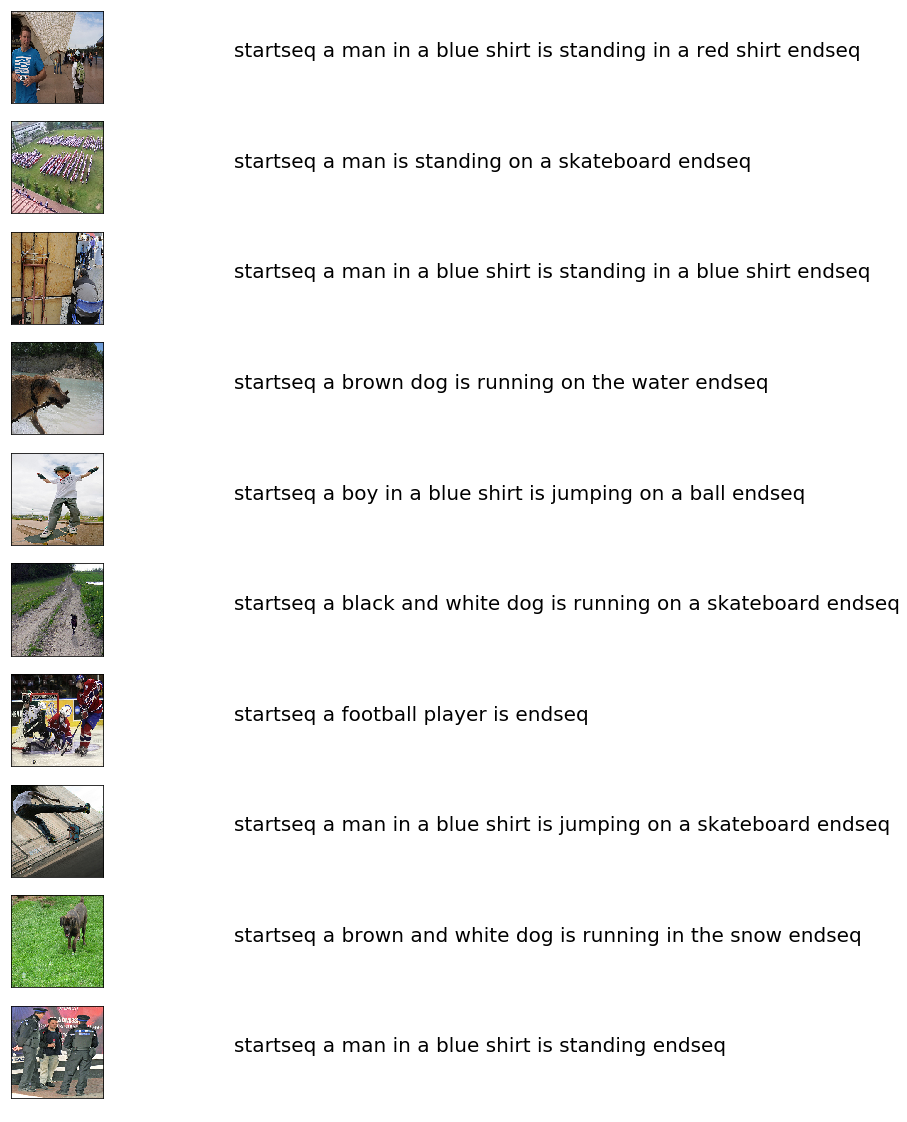

In [0]:
count=1
fig=plt.figure(figsize=(20,40))
for filejpg, img_feat in zip(files_test[:10],imgs_test[:10]):
    img_file="/home/ankit/data set/Flickr8k_Dataset/Flicker8k_Dataset"+"/"+filejpg
    img_load=load_img(img_file,target_size=(224,224,3))
    ax=fig.add_subplot(10,2,count,xticks=[],yticks=[])
    ax.imshow(img_load)
    count+=1

    caption=predict(img_feat.reshape(1,len(img_feat)))
    caption=caption[1:-1]
    ax=fig.add_subplot(10,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count+=1
plt.show()